In [1]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Cartpole control using Iterative Learning Controller

In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
Pkg.add("TrajectoryOptimization")
Pkg.add("RobotDynamics")
Pkg.add("RobotZoo")
Pkg.add("StaticArrays")
Pkg.add("SparseArrays")
Pkg.add("LinearAlgebra")
Pkg.add("ForwardDiff")
Pkg.add("PyPlot")
Pkg.add("OSQP")
using TrajectoryOptimization
using RobotDynamics
const RD = RobotDynamics
import RobotZoo.Cartpole
using StaticArrays
using SparseArrays
using LinearAlgebra
using ForwardDiff
using PyPlot
using OSQP

  Activating project at `~/Documents/Optimal_Control/Sims/Iterative Learning Control`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Manif

In [3]:
model = Cartpole()
n,m = size(model);

In [4]:
N = 101
Tf = 5.
h = Tf/(N-1)

0.05

In [5]:
x0 = @SVector zeros(n)  #cart sitting at origin pole hanging down
xf = @SVector [0, pi, 0, 0];  #i.e. cart at origin but pole swing up

In [6]:
#Set up
Q = 1.0*Diagonal(@SVector ones(n))
Qf = 100.0*Diagonal(@SVector ones(n))
R = 0.1*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

In [7]:
#Create Empty Constraint List
conSet = ConstraintList(n,m,N)

#Control Bounds as torque limits
u_bnd = 5.0
bnd = BoundConstraint(n,m,u_min=-u_bnd,u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

#Goal Constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, (N-5):N)

In [8]:
prob = Problem(model, obj, x0, Tf, xf=xf, constraints=conSet);

In [9]:
u0 = @SVector fill(0.0,m)
U0 = [u0 for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

In [10]:
# Use Altro solver
Pkg.add("Altro")
using Altro
opts = SolverOptions(
        cost_tolerance_intermediate=1e-3,
        penalty_scaling=10.,
        penalty_initial=1.0
)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);

   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Iterative Learning Control/Manifest.toml`
[ Info: Precompiling Altro [5dcf52e5-e2fb-48e0-b826-96f46d2e3e73]



SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 205
    Solve Time: 3539.713186 (ms)

  Covergence
    Terminal Cost: 928.317996972354
    Terminal dJ: 0.04853163702932761
    Terminal gradient: 9.07219858099095e-6
    Terminal constraint violation: 4.63767647396196e-7
    Solve Status: SOLVE_SUCCEEDED


In [11]:
#Extract the solution
Xopt = states(altro);
Uopt = controls(altro);

xnom = zeros(n,N)
for k = 1:N
    xnom[:,k] .= Xopt[k]
end

unom = zeros(m,N-1)
utraj = zeros(m,N-1)
for k = 1:N-1
    unom[:,k] .= Uopt[k]
    utraj[:,k] .= Uopt[k]
end

In [12]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = RD.dynamics(model, x, u)
    f2 = RD.dynamics(model, x + 0.5*h*f1, u)
    f3 = RD.dynamics(model, x + 0.5*h*f2,u)
    f4 = RD.dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

#True model with friction different from a nominal model
function true_dynamics(model::Cartpole, x, u)
    #Perturb masses of cart + pole
    mc = model.mc + 0.02
    mp = model.mp - 0.01
    
    #Perturb length of pendulum
    l = model.l + 0.005
    g = model.g
    
    q = x[@SVector [1,2] ]
    qd = x[@SVector [3,4] ]
    
    s = sin(q[2])
    c = cos(q[2])
    
    H = @SMatrix [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = @SMatrix [0 -mp*qd[2]*l*s; 0 0]
    G = @SVector [0, mp*g*l*s]
    B = @SVector [1, 0]
    
    #nonlinear friction (≈Coulomb/stiction) not present in the nominal(original) dynamics
    F = [0.01; 0.01].*tanh.(5.0*qd)   
    
    qdd = -H\(C*qd + F + G - B*u[1])
    return [qd; qdd]
end

function true_dynamics_rk4(x,u)
    #RK4 integration with ZOH on u
    f1 = true_dynamics(model, x, u)
    f2 = true_dynamics(model, x + 0.5*h*f1, u)
    f3 = true_dynamics(model, x + 0.5*h*f2, u)
    f4 = true_dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

true_dynamics_rk4 (generic function with 1 method)

In [13]:
#Compute A and B matrices using nominal dynamics + trajectory
A = zeros(n,n,N-1)
B = zeros(n,m,N-1)
for k = 1:(N-1)
    A[:,:,k] .= ForwardDiff.jacobian(x->dynamics_rk4(x,Uopt[k]),Xopt[k])
    B[:,:,k] .= ForwardDiff.jacobian(u->dynamics_rk4(Xopt[k],u),Uopt[k])
end

In [14]:
#Compute LQR Tracking Controller
P = zeros(n,n,N)
K = zeros(m,n,N-1)
P[:,:,N] = Qf
for k = (N-1):-1:1
    K[:,:,k] .= (R + B[:,:,k]'*P[:,:,k+1]*B[:,:,k])\(B[:,:,k]'*P[:,:,k+1]*A[:,:,k])
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A[:,:,k]-B[:,:,k]*K[:,:,k])'*P[:,:,k+1]*(A[:,:,k]-B[:,:,k]*K[:,:,k])
end

In [15]:
#Rollout with true dynamics
#Open-loop rollout(comment out first two lines after for loop): 
#                 cart doesn't quie make it back to the origin
#                 pole angle doesn't make it to the top and falls down
#                 railing the torque limits i.e. bang-bang looking input

#Track with LQR(uncomment first and third lines inside for loop):
#                 cart gets to the goal i.e. origin
#                 pole reaches to goal i.e. upright(π)
#                 control inputs violate torqur limits
#Track with LQR plus naively clip control inputs(uncomment all 3 lines inside for loop):
#                cart doesn't get to the goal
#                pole reaches upright
#                control inputs do not violate limits

xtraj = zeros(n,N)
for k = 1:(N-1)
    #utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k]-xnom[:,k])  #with LQR tracking controller
    #utraj[:,k] .= min.(u_bnd, max.(-u_bnd, utraj[:,k]))  #clip values within torque limits
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end
#for ILC run the for loop open-loop

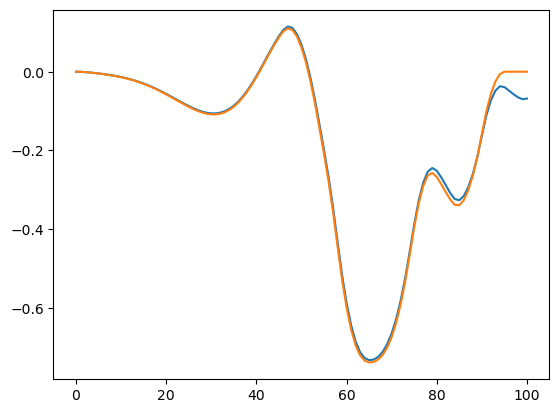

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3c32db640>

In [16]:
plot(xtraj[1,:])
plot(xnom[1,:])

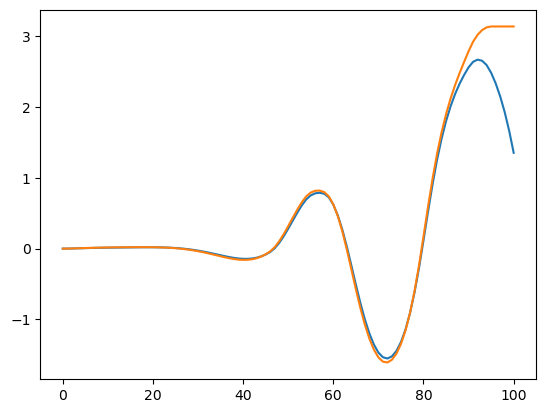

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3c15defa0>

In [17]:
plot(xtraj[2,:])
plot(xnom[2,:])

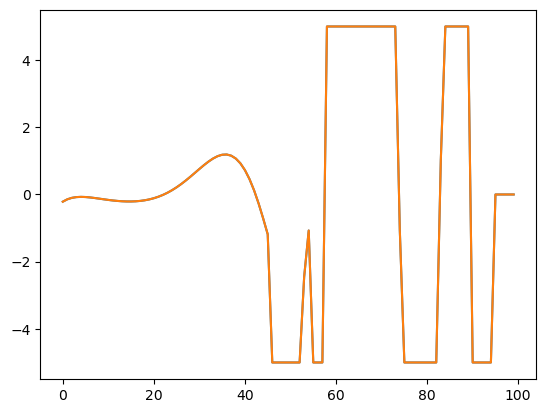

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3c155a940>

In [18]:
plot(utraj[1,:])
plot(Uopt[:])

In [19]:
#Build matrices for ILC QP
#for multiple iterations of ILC,run the rest of code iteratively from this point
Nh = N
Qilc = sparse(Diagonal([0.01; 0; 1.0; 0]))  #vary small costs on the stage cost along the trajectory
Rilc = sparse(Diagonal([.1]))
H = blockdiag(kron(I(Nh-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf)) #big Qfinal
q = zeros((n+m)*(Nh-1))

for k=1:(Nh-2)
    q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(xtraj[:,k+1]-Xopt[k+1])]
end
q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(xtraj[:,Nh]-Xopt[Nh])]

#Constraints
U = kron(I(Nh-1), [I zeros(m,n)])  #Matrix that picks out all u
X = kron(I(Nh-1), [zeros(n,m) I])  #Matrix that picks out all x
D = spzeros(n*(Nh-1), (n+m)*(Nh-1))  #Dynamics constraint

D[1:n,1:m] .= B[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k = 1:(Nh-2)
    D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [A[:,:,k+1] B[:,:,k+1] -I]  #Use linear dynamics constraint
end

lb = [zeros(n*(Nh-1)); -u_bnd.-utraj[1:(Nh-1)]]
ub = [zeros(n*(Nh-1)); u_bnd.-utraj[1:(Nh-1)]]  #Add upper and lower limits bounds on the torque limits constraints

qp = OSQP.Model()
OSQP.setup!(qp, P=H, q=q, A=[D; U], l=lb, u=ub, eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf=1.0e-6, eps_dual_inf=1.0e-6, polish=1)
results = OSQP.solve!(qp)
ztraj = results.x;

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 500, constraints m = 500
          nnz(P) + nnz(A) = 2291
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-06, eps_dual_inf = 1.0e-06,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5479e+03   1.03e-01   4.04e+02   1.00e-01   8.34e-04s
 200  -2.4227e+03   1.85e-06   4.73e-03   8.72e-03   4.88e-03s
 275  -2.4227e+03   1.08e-07   4.26e-04   8.7

In [20]:
Δu = U*ztraj
utraj[1:(Nh-1)] .= utraj[1:(Nh-1)]+Δu

100-element view(::Vector{Float64}, 1:100) with eltype Float64:
 -0.38267681259801867
 -0.2284912392110544
 -0.10524121628571938
 -0.009615823032740917
  0.0608456867816624
  0.1080272583988539
  0.13349807433224578
  0.13874990152822253
  0.12539937241975238
  0.09534747651881326
  0.05089112270389706
 -0.005215796305530124
 -0.06975188150260828
  ⋮
  4.7418360953458185
  4.596938728274095
 -5.0
 -5.0
 -5.0
 -5.0
 -5.0
 -1.815609788586542
 -2.2320245030451313
 -2.766144656571444
 -3.433432969226557
 -4.2501138447292375

In [21]:
xtraj = zeros(n,N)
for k = 1:(N-1)
    #utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k]-xnom[:,k])  #with LQR tracking controller
    #utraj[:,k] .= min.(u_bnd, max.(-u_bnd, utraj[:,k]))  #clip values within torque limits
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end
#for ILC run the for loop open-loop

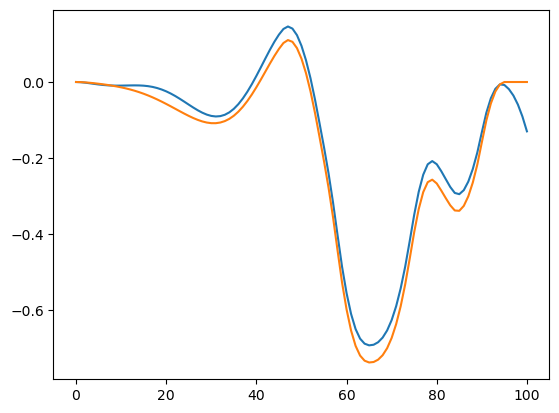

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3c14d07f0>

In [22]:
#Cart position
plot(xtraj[1,:])
plot(xnom[1,:])

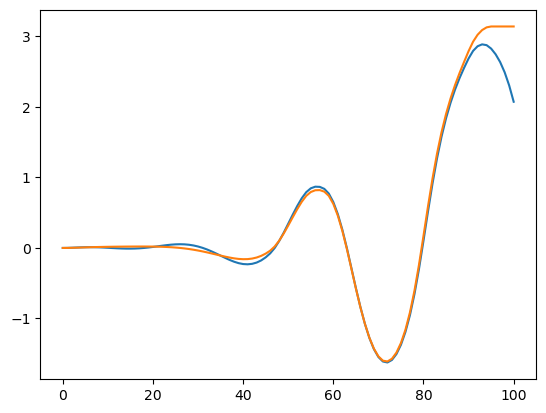

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3c1447550>

In [23]:
#pole angle
plot(xtraj[2,:])
plot(xnom[2,:])

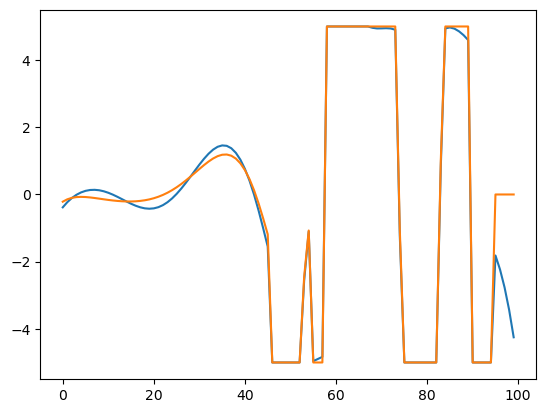

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3c1439760>

In [24]:
#Control inputs
plot(utraj[1,:])
plot(Uopt[:])